In [168]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = ('retina')

In [169]:
import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import tensorflow_datasets as tfds

## Load dataset

In [170]:
dataset, dataset_info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)

In [171]:
# check dataset is a dictinary
print("Type of dataset:",type(dataset))

# print the keys in dataset
print("Keys in the dict are:",dataset.keys())

Type of dataset: <class 'dict'>
Keys in the dict are: dict_keys(['test', 'train'])


In [172]:
training_set, test_set = dataset['train'], dataset['test']

In [195]:
print(test_set)

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


In [174]:
# display dataset info
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [175]:
shape_images = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes

num_training_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print("There are {} classes in datasets".format(num_classes))
print('The images in the dataset have shape {}'.format(shape_images))

print('The number of training images are {}'.format(num_training_examples))
print('The number of test images are {}'.format(num_test_examples))



There are 10 classes in datasets
The images in the dataset have shape (28, 28, 1)
The number of training images are 60000
The number of test images are 10000


In [176]:
dataset_info.features.keys()

dict_keys(['image', 'label'])

In [177]:
dataset_info.features.items()

dict_items([('image', Image(shape=(28, 28, 1), dtype=tf.uint8)), ('label', ClassLabel(shape=(), dtype=tf.int64, num_classes=10))])

## Explore the dataset

In [178]:
dataset_info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=10)

In [179]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [180]:
for image, label in training_set.take(1):
    print("The images in the training set have :\n\u2022 dtypes", image.dtype,"\n\u2022 shape",image.shape)

The images in the training set have :
• dtypes <dtype: 'uint8'> 
• shape (28, 28, 1)


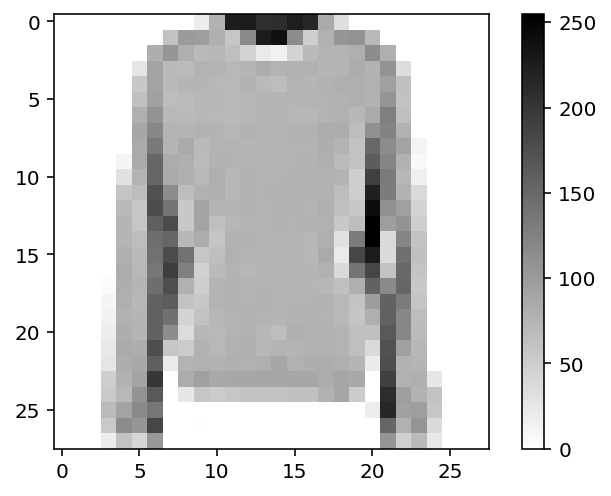

The label of the image is: 2
The class name of the image is: Pullover


In [181]:
# to plot an image from dataset
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
plt.imshow(image, cmap = plt.cm.binary)
plt.colorbar()
plt.show()

print("The label of the image is:",label)
print("The class name of the image is:",class_names[label])

## Create Pipeline

In [182]:
def normalize(image,label):
    image = tf.cast(image, tf.float32)
    label /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
test_batch = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

print(test_batch)

<DatasetV1Adapter shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.float64)>


## Build the model

In [183]:
class Network(tf.keras.Model):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.input_layer = tf.keras.layers.Flatten()
        self.hidden_layer_1 = tf.keras.layers.Dense(256,activation = 'relu')
        self.hidden_layer_2 = tf.keras.layers.Dense(128,activation = 'relu')
        self.hidden_layer_3 = tf.keras.layers.Dense(64,activation = 'relu')
        self.output_layer = tf.keras.layers.Dense(10, activation = 'softmax')
        
    def call(self, input_tensor):
        x = self.input_layer(input_tensor)
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)
        x = self.output_layer(x)
        return x
    
model = Network(10)

model.build((None, 28,28,1))
model.get_layer(index=3).get_weights()[0].shape

(128, 64)

### Train and evaluate the model

In [184]:
tf.keras.optimizers

<module 'tensorflow_core.keras.optimizers' from '/Users/itisrv/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/api/_v2/keras/optimizers/__init__.py'>

In [185]:
tf.keras.losses.Loss

tensorflow.python.keras.losses.Loss

In [186]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [187]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

64/64 [==============================] - 0s 1ms/sample - loss: 273.5684 - accuracy: 0.0000e+00


In [188]:
loss, accuracy = model.evaluate(training_batches)

    938/Unknown - 8s 9ms/step - loss: 276.6108 - accuracy: 0.0000e+00

In [189]:
epochs = 5

history = model.fit(training_batches, epochs= epochs)

Epoch 1/5
938/938 [==============================] - 6s 7ms/step - loss: 0.3394 - accuracy: 0.0998
Epoch 2/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 3/5
938/938 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1000
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0000e+00 - accuracy: 0.1000


## Evaluate loss and accuracy on the test set

In [192]:
loss, accuracy = model.evaluate(test_batch)

    157/Unknown - 2s 11ms/step - loss: 0.0000e+00 - accuracy: 0.1000

#### On a single image

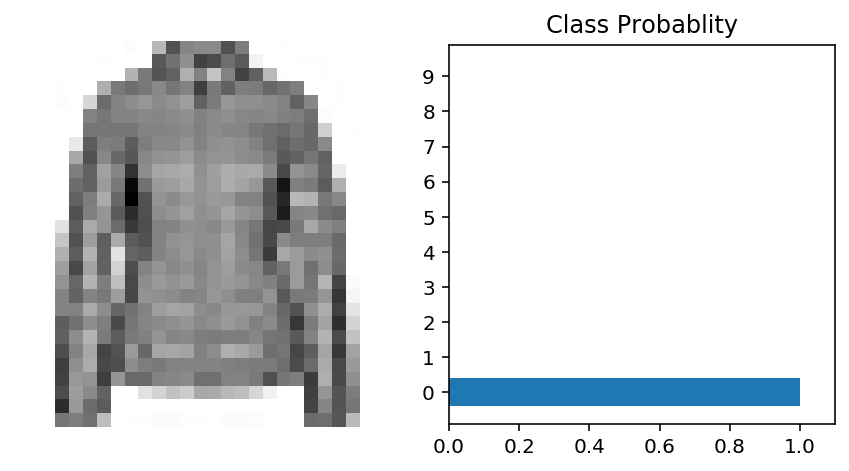

In [205]:
for image_batch, label_batch in test_batch.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    first_label = label_batch.numpy()[0]
    
fig, (ax1, ax2) = plt.subplots(figsize =(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
#ax1.set_title(class_names[first_label])

ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
#ax2.set_yticklabels(class_names, size ='small')
ax2.set_title("Class Probablity")
ax2.set_xlim(0,1.1)

plt.tight_layout()